In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [3]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [3]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [4]:
gene_df, _, _ = get_gtf_info(how='gene')

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya))

Detected 24936 / 49472 annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## Protein coding gene transcript detection

What fraction of protein-coding genes do we detect with at least 1 known isoform >= 1 TPM in any library?

In [26]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
# no gene subset here so we can look at all other genes
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1)

Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Number of isos reported: 77128


In [27]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [28]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')
df = df.merge(gene_df, how='left', left_on='annot_gene_id', right_on='gid')

In [29]:
df.head()

,gm12878_1_1,gm12878_1_2,gm12878_1_3,gm12878_1_4,gm12878_3_1,gm12878_2_1,gm12878_2_2,pgp1_1_1,pgp1_1_2,h9_1_1,...,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1,annot_gene_id,annot_transcript_id,gid,length,biotype,biotype_category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,ENSG00000243485.5,ENST00000469289.1,ENSG00000243485.5,1555,lincRNA,lncRNA
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,1.618796,0.000000,...,0.0,0.0,0.0,0.0,ENSG00000237613.2,ENST00000417324.1,ENSG00000237613.2,1527,lincRNA,lncRNA
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,0.000000,0.000000,...,0.0,0.0,0.0,0.0,ENSG00000237613.2,ENST00000461467.1,ENSG00000237613.2,1527,lincRNA,lncRNA
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,ENSG00000233750.3,ENST00000442987.3,ENSG00000233750.3,3811,processed_pseudogene,pseudogene
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,6.475185,1.242064,...,0.0,0.0,0.0,0.0,ENSG00000268903.1,ENST00000494149.2,ENSG00000268903.1,754,processed_pseudogene,pseudogene


In [30]:
temp = df[['gid', 'biotype_category']].drop_duplicates().groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,17052,19969,0.853924
0,lncRNA,4777,15006,0.318339
2,other,1908,7426,0.256935
1,miRNA,418,1881,0.222222
4,pseudogene,3107,14497,0.214320


## What fraction of protein coding gene transcripts do we detect?

Of the transcripts associated with protein coding genes GENCODE, how many do we detect >=1 1 TPM?

In [31]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [32]:
t_df, b_counts, b_cat_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [34]:
temp = df[['tid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'tid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
1,protein_coding,64084.0,151259,0.423671
0,lncRNA,7073.0,28478,0.248367
2,pseudogene,3639.0,17657,0.206094
3,miRNA,NaN,1881,NaN
4,other,NaN,7486,NaN


## Characteristics of detected known, polyA gene associated transcripts

## Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796
Found 31 total samples


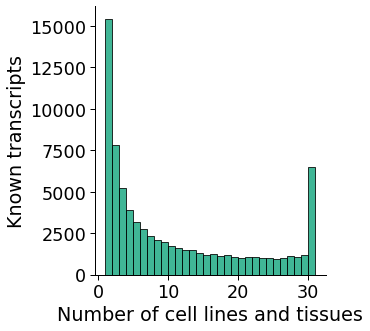

In [2]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = plot_biosamp_det(df,
                      how='iso',
                      min_tpm=1,
                      gene_subset='polya',
                      sample=None,
                      groupby='sample',
                      nov='Known',
                      opref='figures/human')

In [9]:
specific_thresh = 4
ubiq_thresh = 20

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

32327 / 74796 (43.2%) transcripts are expressed in <= 4 samples
16872 / 74796 (22.6%) transcripts are expressed in >= 20 samples


## Length of transcripts from polyA genes detected >= 1 TPM

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


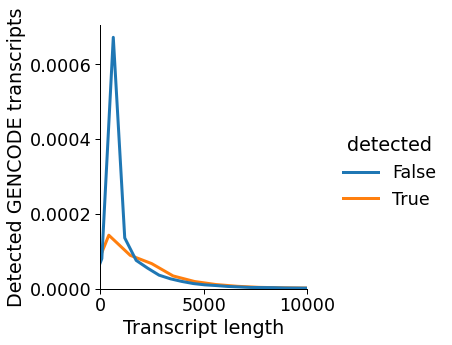

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='iso', 
                      subset='polya',
                      min_tpm=1,
                      xlim=10000,
                      opref='figures/')

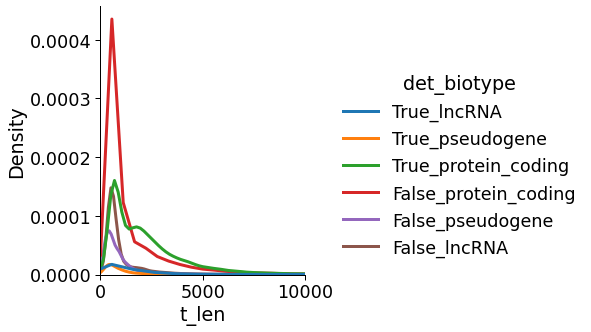

In [9]:
df['det_biotype'] = df.detected.astype('str')+'_'+df.biotype_category
ax = sns.displot(data=df, x='t_len', kind='kde',
                     linewidth=3, hue='det_biotype', common_norm=True)
ax.set(xlim=(0,10000))

What is the longest detected transcript with more than one exon?

In [7]:
t_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
t_df = t_df[['annot_transcript_id', 'n_exons']]

In [9]:
df = df.merge(t_df, how='left', on='annot_transcript_id')

In [10]:
n = df.loc[(df.detected == True)&(df.n_exons > 1), 't_len'].max()
print(n)

37852


In [11]:
df.loc[df.t_len == 37852]

,annot_transcript_id,tid,t_len,gid,biotype,biotype_category,detected,n_exons
70907,ENST00000458178.2,ENST00000458178.2,37852,ENSG00000224086.5,antisense,lncRNA,True,2.0


## Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [41]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


## How many known polyA transcripts do we detect?

In [7]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [8]:
# merge with transcript len
t_df, b_counts, c_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [17]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
n_det_polya = len(df.index)
n_known_polya = c_counts.loc[c_counts.biotype_category.isin(polya_biotypes), 'gencode_counts'].sum()
print('Detected {} / {} annotated transcripts from polyA genes >= 1 TPM'.format(n_det_polya, n_known_polya))

Detected 74796 / 197394 annotated transcripts from polyA genes >= 1 TPM


## How many complete isoforms do we detect?

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027


  transcript_novelty  counts
0              Known   73961
1                NIC   18270
2                NNC    5796
Number of complete isoforms: 98027


<Figure size 288x432 with 0 Axes>

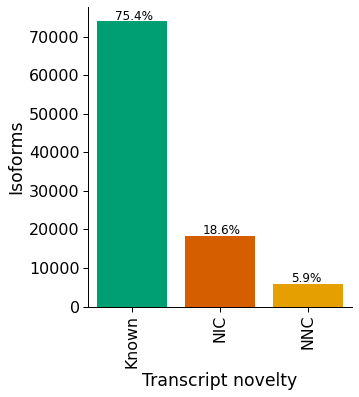

<Figure size 432x288 with 0 Axes>

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty(df,
                        oprefix='figures/complete_det',
                        whitelist=tids,
                        novs=['Known', 'NIC', 'NNC'])

## How many exons are in each complete, detected model, split by novelty?

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027


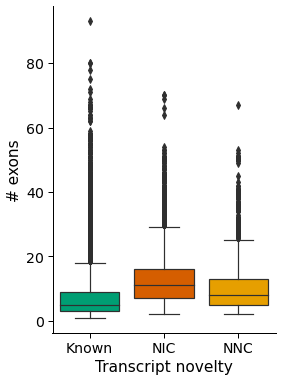

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_exons_per_iso(df,
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya',
                   opref='figures/human')

## How many isoforms per gene do we detect per sample? 

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [11]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_det_table(df, 
              how='iso',
              min_tpm=1,
              gene_subset='polya',
              groupby='sample',
              nov=['Known', 'NIC', 'NNC'])
g_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples


In [12]:
df = df.transpose()

In [13]:
df.head()

biosample,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,mcf7,muscle,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels
ENST00000469289.1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
ENST00000417324.1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
ENST00000461467.1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
ENST00000442987.3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
ENST00000494149.2,False,True,False,False,True,False,True,False,False,False,...,True,False,False,False,True,True,True,True,True,True


In [14]:
# merge with gene info
g_df = g_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(g_df, how='left', left_index=True, right_on='annot_transcript_id')

In [15]:
df.head()

,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,annot_gene_id,annot_transcript_id
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,ENSG00000243485.5,ENST00000469289.1
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,ENSG00000237613.2,ENST00000417324.1
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,ENSG00000237613.2,ENST00000461467.1
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,ENSG00000233750.3,ENST00000442987.3
4,False,True,False,False,True,False,True,False,False,False,...,False,False,True,True,True,True,True,True,ENSG00000268903.1,ENST00000494149.2


In [20]:
temp = df.drop(['annot_transcript_id'], axis=1).copy(deep=True)
temp.set_index('annot_gene_id', inplace=True)
temp = temp.astype(int)
temp.reset_index(inplace=True)
temp.head()
temp = temp.groupby('annot_gene_id').sum()

In [21]:
temp.head()

,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,mcf7,muscle,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels
annot_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.14,4,3,6,1,6,2,5,6,5,6,...,4,2,5,3,3,5,3,4,3,4
ENSG00000000005.5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419.12,2,4,5,6,5,6,4,7,5,5,...,5,4,4,5,5,5,6,3,5,6
ENSG00000000457.13,1,2,1,3,2,2,2,4,3,1,...,1,2,3,2,1,1,2,1,0,1
ENSG00000000460.16,0,2,2,5,3,2,2,5,2,3,...,3,0,2,2,1,4,1,1,2,1


In [22]:
df.loc[(df.annot_gene_id == 'ENSG00000000003.14')]

,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,annot_gene_id,annot_transcript_id
84041,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,ENSG00000000003.14,ENST00000373020.8
84042,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,ENSG00000000003.14,ENST00000496771.5
109499,False,True,True,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,True,ENSG00000000003.14,ENCODEHT000604780
109500,True,False,True,False,True,False,True,True,True,True,...,True,False,False,True,False,True,False,False,ENSG00000000003.14,ENCODEHT000604781
109501,True,False,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,ENSG00000000003.14,ENCODEHT000604787
109503,True,True,True,False,True,False,True,True,True,True,...,True,True,True,True,True,True,False,True,ENSG00000000003.14,ENCODEHT000604797
109507,False,False,True,False,True,False,False,True,False,True,...,False,False,False,True,False,False,True,False,ENSG00000000003.14,ENCODEHT000604867
